# RandomForest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, mean_squared_error, confusion_matrix

In [3]:
data = pd.read_csv('./data/data_processed.csv')

data['target'] = data['readmitted'].isin(['<30']).astype(int)

data = data.drop(columns='readmitted')

In [4]:
X = data.drop(columns = 'target')
y = data['target']

In [5]:
X['strat_col'] = X['race'].astype(str) + "_" + data['target'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_test_copy = X_test.copy(deep = True)

X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

In [17]:
#with a reasonable set of parameters (not calibrated)

rf = RandomForestClassifier(n_estimators=1000,
                            criterion='gini', 
                            max_depth=10,
                            min_samples_split=3,
                            min_samples_leaf=2, 
                            max_features='sqrt', 
                            max_leaf_nodes=None, 
                            bootstrap=True, 
                            oob_score=False,
                            n_jobs=-1, 
                            random_state=42,
                            verbose=1, 
                            warm_start=False, 
                            class_weight=None)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
y_predprobs = rf.predict_proba(X_train)[:,1]

print ("\nModel Report")
print ("Cassification report:\n", classification_report(y_train, y_pred))
print ("Accuracy : ", accuracy_score(y_train, y_pred))
print ("AUC Score : " , roc_auc_score(y_train, y_predprobs))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps


Model Report
Cassification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     68785
           1       0.95      0.03      0.05      8901

    accuracy                           0.89     77686
   macro avg       0.92      0.51      0.50     77686
weighted avg       0.90      0.89      0.84     77686

Accuracy :  0.8882552840923719
AUC Score :  0.8483900633050477


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


### Using grid search to tune

#### First search: `max_depth`

In [31]:
%%time
best_params_GS = {}

param_test_1 = {
    'max_depth': range(5, 31, 5)
}
gsearch_1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=1000, random_state = 42), 
 param_grid = param_test_1, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_1.fit(X_train,y_train)

best_params_GS.update(gsearch_1.best_params_)
print("The best parameters are:", gsearch_1.best_params_)
print("Best AUC score = ",gsearch_1.best_score_)

The best parameters are: {'max_depth': 15}
Best AUC score =  0.8026882345651224
CPU times: total: 53.6 s
Wall time: 4min 13s


#### Second search: `max_features`

In [37]:
list_feat = np.arange(0.2, 1.2, 0.2).tolist()
list_feat.extend(['sqrt','log2'])

In [49]:
%%time

param_test_2 = {'max_features': list_feat}

gsearch_2 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators = 1000, random_state = 42), 
 param_grid = param_test_2, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_2.fit(X_train,y_train)

best_params_GS.update(gsearch_2.best_params_)
print("The best parameters are:", gsearch_2.best_params_)
print("Best AUC score = ",gsearch_2.best_score_)

The best parameters are: {'max_features': 0.4}
Best AUC score =  0.8148836539999011
CPU times: total: 2min 41s
Wall time: 16min 50s


#### Third search: `criterion` and `bootstrap`

In [51]:
%%time

param_test_3 = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
}

gsearch_3 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators = 1000,  random_state = 42), 
 param_grid = param_test_3, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_3.fit(X_train,y_train)

best_params_GS.update(gsearch_3.best_params_)
print("The best parameters are:", gsearch_3.best_params_)
print("Best AUC score = ",gsearch_3.best_score_)

The best parameters are: {'bootstrap': True, 'criterion': 'entropy'}
Best AUC score =  0.8185440258431227
CPU times: total: 2min 39s
Wall time: 14min 11s


#### Fourth search: `min_samples_split`

In [52]:
%%time

param_test_4 = {'min_samples_split': range(5, 21, 5)}

gsearch_4 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators=1000, random_state = 42), 
 param_grid = param_test_4, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_4.fit(X_train,y_train)

best_params_GS.update(gsearch_4.best_params_)
print("The best parameters are:", gsearch_4.best_params_)
print("Best AUC score = ",gsearch_4.best_score_)

The best parameters are: {'min_samples_split': 20}
Best AUC score =  0.8195231093159645
CPU times: total: 2min 36s
Wall time: 10min 4s


#### Final search: `min_samples_leaf`

In [56]:
%%time

param_test_5 = {
    'min_samples_leaf': [1, 5, 10, 20, 50]
}

gsearch_5 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators=1000, random_state = 42), 
 param_grid = param_test_5, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_5.fit(X_train,y_train)

best_params_GS.update(gsearch_5.best_params_)
print("The best parameters are:", gsearch_5.best_params_)
print("Best AUC score = ",gsearch_5.best_score_)

The best parameters are: {'min_samples_leaf': 20}
Best AUC score =  0.8215943482097512
CPU times: total: 2min 10s
Wall time: 9min 46s


In [57]:
#final list of tuned parameters
best_params_GS

{'max_depth': 15,
 'max_features': 0.4,
 'bootstrap': True,
 'criterion': 'entropy',
 'min_samples_split': 20,
 'min_samples_leaf': 20}

### Alternate: Using Random Search

In [39]:
%%time

parameters = {
    'max_depth': range(5, 31, 5),
    'max_features': list_feat,
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(n_estimators= 1000, random_state = 42)

random_search = RandomizedSearchCV(estimator = rf, n_iter = 50,
                           param_distributions=parameters,
                           scoring = 'roc_auc',
                           n_jobs=-1, verbose=1, cv=5)

random_search.fit(X_train, y_train)

best_params_RS = random_search.best_params_

print("Best parameters:\n",random_search.best_params_,"\n")
print("Best AUC score = ",random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:
 {'max_features': 0.8, 'max_depth': 10, 'criterion': 'log_loss', 'bootstrap': True} 

Best AUC score =  0.8217319853994338
CPU times: total: 4min 1s
Wall time: 1h 38min


In [58]:
best_params_RS

{'max_features': 0.8,
 'max_depth': 10,
 'criterion': 'log_loss',
 'bootstrap': True}

Choosing the grid search parameters

In [60]:
best_params = best_params_GS#best_params_RS

### Fit and evaluation

In [64]:
%%time
rfCal = RandomForestClassifier(**best_params, n_estimators=1000, random_state=42)

rfCal.fit(X_train, y_train)

CPU times: total: 2min 21s
Wall time: 2min 36s


RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.4,
                       min_samples_leaf=20, min_samples_split=20,
                       n_estimators=1000, random_state=42)

In [65]:
probs = rfCal.predict_proba(X_test)
y_pred = (probs[:, 1]>=0.5)

Confusion Matrix:
[[17155    42]
 [ 2166    59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17197
           1       0.58      0.03      0.05      2225

    accuracy                           0.89     19422
   macro avg       0.74      0.51      0.50     19422
weighted avg       0.85      0.89      0.84     19422

Mean squared error =  0.11368551127587272
Accuracy =  0.8863144887241273
ROC AUC score =  0.8157575955565807


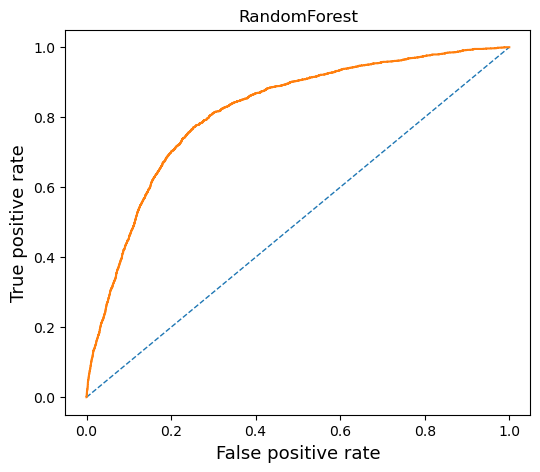

In [66]:
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/roc_curve_rf.csv', index=False)
    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('RandomForest')
plt.show()

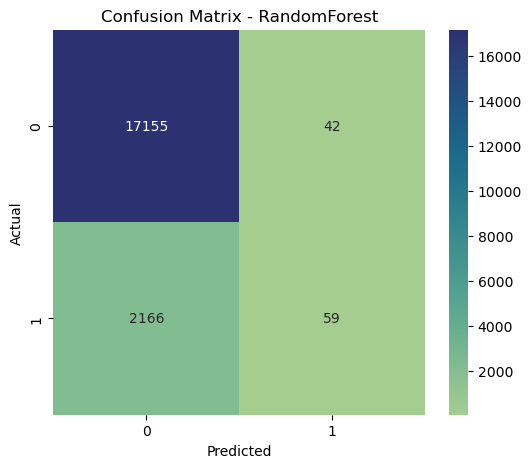

Confusion Matrix:
 [[17155    42]
 [ 2166    59]]


In [67]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RandomForest')

plt.savefig('./figs/conf_mat_rf.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)